# 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# 2. Importing and visualizing data

### 2.1 Original features

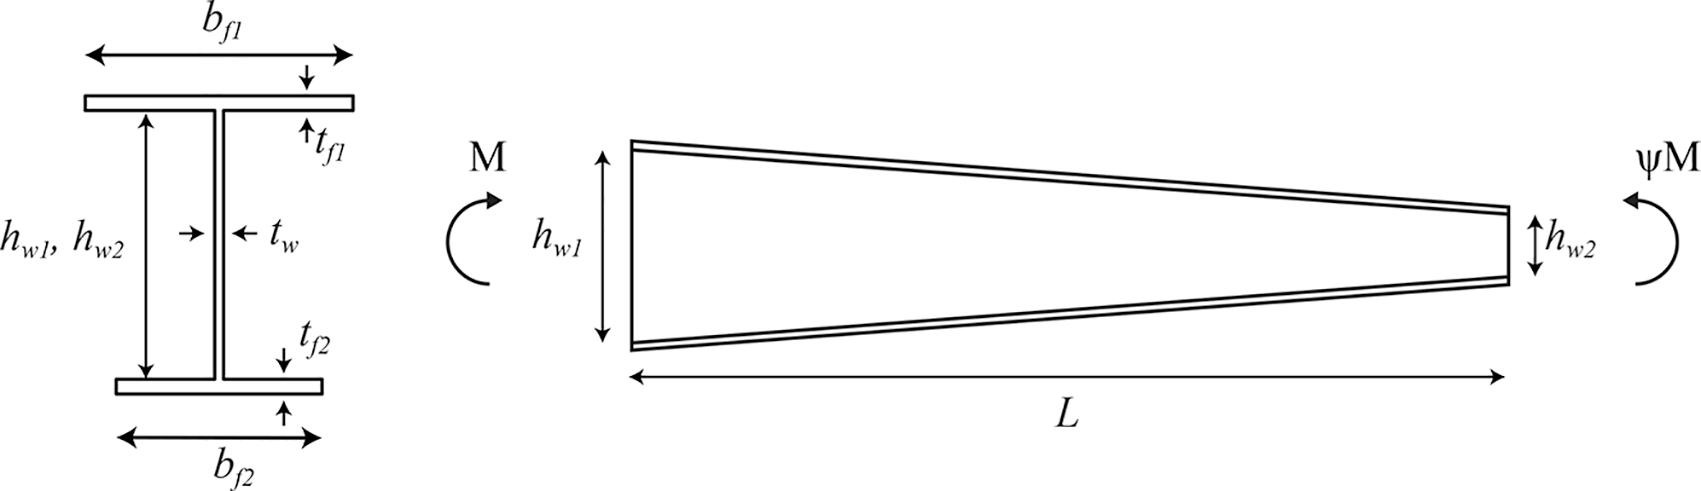

In [ ]:
from IPython import display
display.Image("1-s2.0-S2352012422004581-gr4_lrg.jpg")

In [ ]:
df = pd.read_csv("training_set.csv", sep=';')
df.head()

,hw1,hw2,tw,bf1,tf1,bf2,tf2,psi,L,y
0,500,167,2.09,500,17.89,375,13.42,-0.75,19000,1703.681777
1,700,280,4.75,525,34.26,700,40.53,-0.75,28000,6745.446061
2,400,400,1.67,100,6.89,300,18.47,0.75,8000,143.526934
3,160,400,3.43,200,9.37,100,6.89,-0.25,7200,145.486862
4,100,400,1.33,300,15.16,300,4.11,1.00,5600,643.674997


In [ ]:
df.info()
# All the variables are floats or integers.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60549 entries, 0 to 60548
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hw1     60549 non-null  int64  
 1   hw2     60549 non-null  int64  
 2   tw      60549 non-null  float64
 3   bf1     60549 non-null  int64  
 4   tf1     60549 non-null  float64
 5   bf2     60549 non-null  int64  
 6   tf2     60549 non-null  float64
 7   psi     60549 non-null  float64
 8   L       60549 non-null  int64  
 9   y       60549 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 4.6 MB


In [ ]:
df.isnull().sum()
# there are no NaN values

hw1    0
hw2    0
tw     0
bf1    0
tf1    0
bf2    0
tf2    0
psi    0
L      0
y      0
dtype: int64

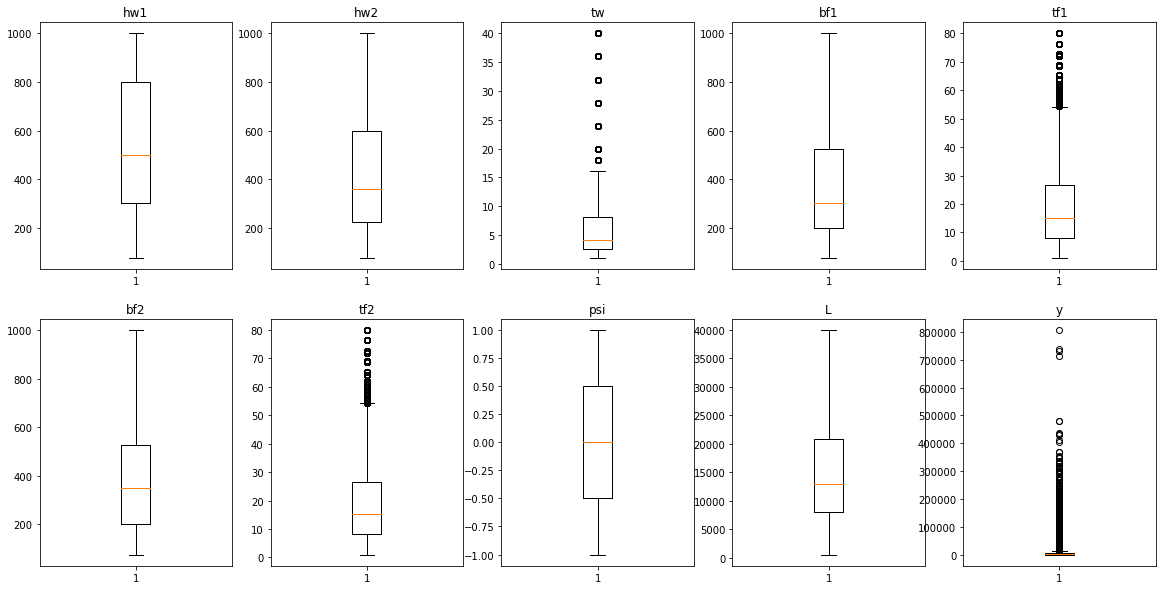

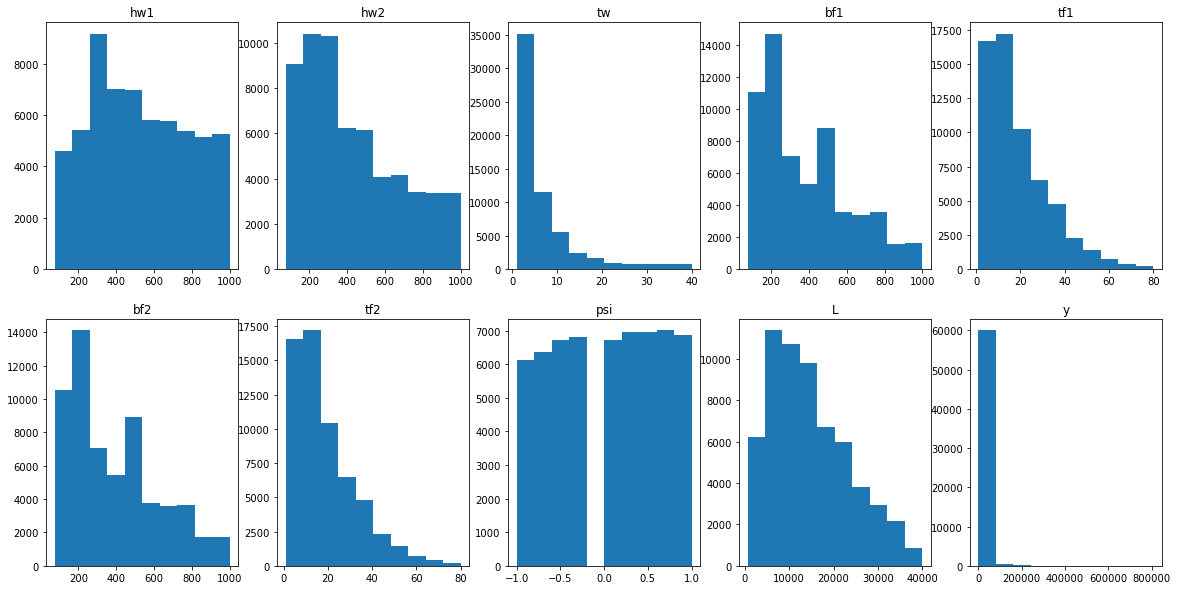

In [ ]:
# Boxplots
plt.figure(figsize=(20,10))
for i in range(len(df.columns)):
    plt.subplot(2,5,i+1)
    plt.boxplot(df.iloc[:,i])
    plt.title(df.columns[i])

# Histograms
plt.figure(figsize=(20,10))
for i in range(len(df.columns)):
    plt.subplot(2,5,i+1)
    plt.hist(df.iloc[:,i])
    plt.title(df.columns[i])

# 3. Feature engineering

### 3.1 Eliminating samples with outliers in target variable

In [2]:
def df_outlier_elimination(df):
    y = df.copy().iloc[:, -1].values
    y_sort = np.sort(y)
    # quantiles
    Q1 = y_sort[round(len(y_sort)*0.25)]
    Q3 = y_sort[round(len(y_sort)*0.75)]
    # indices of outliers
    lower_indices = [i for i in range(len(y)) if y[i] < Q1-1.5*(Q3-Q1)]
    upper_indices = [i for i in range(len(y)) if y[i] > Q1+1.5*(Q3-Q1)]
    
    return df.copy().drop(index = lower_indices + upper_indices)

### 3.2 Generated features

</br>Taper ratio
- $h_{w, max}/h_{w, min}$

</br>Flange width ratio
- $b_{f1}/b_{f2}$

</br>Height to width ratio
- $h_{w, max}/b_{f, max}$

</br>Beam length
- $L/h_{w, max}$

</br>Plate thickness ratio
- $t_{f1}/t_{w}; t_{f2}/t_{w}$

</br>Flange slenderness
- $b_{f1}/t_{f1}; b_{f2}/t_{fs}$

</br>Web slenderness
- $h_{w, max}/t_{w}$;

In [3]:
def df_extend(df):
    """
    this function creates new variables useful for the model
    these new variables are explained in the original paper
    """
    df_extended = df.copy()

    # creating new features
    df_extended["taper_ratio"] = df[["hw1","hw2"]].max(axis=1) / df[["hw1","hw2"]].min(axis=1)
    df_extended["flange_width_ratio"] = df.bf1 / df.bf2
    df_extended["height_to_width_ratio"] = df[["hw1","hw2"]].max(axis=1) / df[["bf1","bf2"]].max(axis=1)
    df_extended["beam_length"] = df.L / df[["hw1","hw2"]].max(axis=1)
    df_extended["plate_thickness_ratio_1"] = df.tf1 / df.tw
    df_extended["plate_thickness_ratio_2"] = df.tf2 / df.tw
    df_extended["flange_slenderness_1"] = df.bf1 / df.tf1
    df_extended["flange_slenderness_2"] = df.bf2 / df.tf2
    df_extended["web_slenderness"] = df[["hw1", "hw2"]].max(axis=1) / df.tw

    # change y position
    y_aux = df_extended.y
    df_extended = df_extended.drop(columns="y")
    df_extended["y"] = y_aux

    return df_extended

# df_extended = df_extend(df)

### 3.3 Plotting data with new features and filtered target

In [4]:
df_new = df_outlier_elimination( df_extend(df) )
%matplotlib inline
# Boxplots
plt.figure(figsize=(20,15))
for i in range(len(df_new.columns)):
    plt.subplot(4,5,i+1)
    plt.boxplot(df_new.iloc[:,i])
    plt.title(df_new.columns[i])

# Histograms
plt.figure(figsize=(20,15))
for i in range(len(df_new.columns)):
    plt.subplot(4,5,i+1)
    plt.hist(df_new.iloc[:,i])
    plt.title(df_new.columns[i])

NameError: name 'df' is not defined

### 3.4 Creating polynomial features

In [5]:
def df_poly(df, degree = 2):
    """
    this function takes the original dataframe and creates an X dataframe, 
    adding the squared features from the original ones
    """
    frame = df.copy()

    if degree < 2:
        print("ERROR: degree must be an integer equal or greater than 2")

    for i in range(2, degree + 1):
        for feature in frame.drop(columns="y"):
            frame[str(i)+"_"+feature] = frame[feature] ** (i)

    y = frame.y
    frame = frame.drop(columns="y")
    frame["y"] = y

    return frame

### 3.5 Feature selection

Feature selection resorting to Lasso regression

In [6]:
def l1_feature_score(X, y):
    
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import GridSearchCV

    # potential alpha values
    parameters = {"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]}
    # grid search for best alpha
    clf = GridSearchCV(Lasso(), parameters)
    clf = clf.fit(X, y)
    alpha = clf.best_params_["alpha"]
    # feature scoring
    lasso = Lasso(alpha = alpha)
    lasso.fit(X, y)
    feature_score = lasso.coef_

    return feature_score

# 4. Linear regression

This code was taken from the second class of Fundamentals of Machine Learning.

### 4.1 Cost function

In [ ]:
def computeCost(X, y, theta):
    """
    Take the arrays X, y, theta and return cost function J for this theta. 
    """
    # number of samples
    m = X.shape[0]
    
    # linear regression model
    h = np.dot(X, theta)
    
    # cost
    J = 1/(2*m)*np.sum((h-y)**2)
        
    return J

### 4.2 Gradient descent of the cost function function

In [ ]:
def gradientDescent(X, y, theta, alpha, num_iters):
    """
    Take arrays X, y and theta and update theta over num_iters steps 
    with learning rate alpha
    Return: final vector theta and the values of the cost function 
    for each iteration (J_history) 
    """
    
    # number of samples
    m = X.shape[0]
    # vector to store cost values over iterations
    J_history = []
    
    for i in range(num_iters):
        
        # linear regression model
        h = np.dot(X, theta)
        # all gradients simultaneously 
        grad = np.dot(X.transpose(), (h-y)) / m 
        # opdate vector theta for each iteration
        theta = theta - alpha*grad
        # cost
        J = computeCost(X, y, theta)
        J_history.append(J)
    
    return theta, J_history

### 4.3 Prediction function

In [ ]:
def predict(x, theta):
    """
    Takes array of x and theta and return the predicted value of y 
    """
     #compute the linear regression model
    x = np.array([1, x])
    h = np.dot(x, theta)
    
    return h

### 4.4 Implementing the steps above described

First steps

In [ ]:
df_new = df_extend(df.copy())
df_new = df_outlier_elimination(df_new)
df_new = df_poly(df_new)

X = df_new.drop(columns = "y").values
y = df_new["y"].values

# number of samples (m) and features with extra one (n)
m = X.shape[0]
n = X.shape[1] + 1

# reshaping y
y = y.reshape(m, 1)

# normalization and add column of 1s
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm = np.append(np.ones((m,1)), X_norm, axis = 1)

Gradient descent

In [ ]:
initial_theta = np.zeros((n, 1))
alpha = [0.001, 0.01, 0.1, 0.2]
theta_J = dict()
num_iters = 500

for i in range(len(alpha)):
    theta, J_history = gradientDescent(X_norm, y, initial_theta, alpha[i], num_iters)
    var = {}
    var["theta"] = theta
    var["J_history"] = J_history
    theta_J[i] = var

Lowest cost: 349912.52855848544


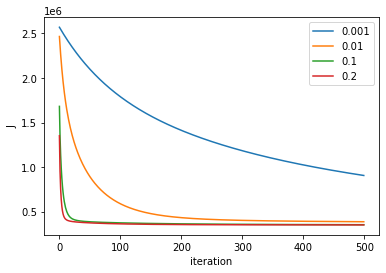

In [ ]:
plt.figure()
for i in range(len(alpha)):
    plt.plot(theta_J[i]["J_history"])
plt.legend(alpha)
plt.xlabel("iteration")
plt.ylabel("J")

print("Lowest cost:", theta_J[3]["J_history"][-1])

As we can see, it is not enough to implement a simple linear regression model, since the lowest cost possible is of order $10^8$. Therefore, this enphasizes the need to use a more complex model for prediction.

In [7]:
def model1_fit(df, poly_degree = 2, num_iters = 500):

    import warnings
    from sklearn.exceptions import ConvergenceWarning
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    # synthetic features
    df_new = df_outlier_elimination(df.copy())
    # compund features
    df_new = df_extend(df_new)
    # polynomial features
    df_new = df_poly(df_new, degree = poly_degree)
    
    # arrays
    X = df_new.iloc[:,:-1].values
    y = df_new.iloc[:,-1].values

    # features scoring
    feat_scores = l1_feature_score(X, y)
    feat_scores = feat_scores/np.sum(feat_scores)
    # features selection with more than 5% of score
    SelectedFeatures_index = [i for i in range(len(feat_scores)) if feat_scores[i] >= 0.02]

    # new X
    X_select = X[:, SelectedFeatures_index]

    # number of samples (m) and features with extra one (n)
    m = X_select.shape[0]
    n = X_select.shape[1] + 1

    # reshaping y
    y = y.reshape(m, 1)

    # normalization and add column of 1s
    scaler = StandardScaler()
    X_norm = scaler.fit_transform(X_select)
    X_norm = np.append(np.ones((m, 1)), X_norm, axis = 1)

    # initialization of parameters for regression
    initial_theta = np.zeros((n, 1))
    alpha = [0.001, 0.01, 0.1, 0.3]
    theta_J = dict()

    # tunning of function
    for i in range(len(alpha)):
        theta, J_history = gradientDescent(X_norm, y, initial_theta, alpha[i], num_iters)
        theta_J[i] = dict()
        theta_J[i]["theta"] = theta
        theta_J[i]["J_history"] = J_history

    return theta_J, SelectedFeatures_index
    

Importing data to test the model

In [ ]:
df_test = pd.read_csv("testing_set.csv", sep=";")

Searching for missing values

In [ ]:
df_test.isnull().sum()

# there are no missing values in the training test

hw1    0
hw2    0
tw     0
bf1    0
tf1    0
bf2    0
tf2    0
psi    0
L      0
y      0
dtype: int64

Creating compound features, creating polynomial features, selecting features, and normalization

In [ ]:
# training the model the model
theta_J, SelectedFeatures_index = model1_fit(df, poly_degree = 4, num_iters = 500)

In [ ]:
theta_J[3]["theta"].shape

(12, 1)

In [ ]:
# compund features
df_test_new = df_extend(df_new)
# polynomial features
df_test_new = df_poly(df_new, degree = 4)

# test arrays
X_test = df_test_new.iloc[:,:-1].values
X_test = X_test[:, SelectedFeatures_index]
y_test = df_test_new.iloc[:,-1].values.reshape(len(df_test_new), 1)

# feature engineering
X_test_norm = StandardScaler().fit_transform(X_test)
X_test_norm = np.append( np.ones((X_test_norm.shape[0], 1)), X_test_norm, axis = 1 ) #adding column of ones

# prediciton
y_predict = X_test_norm @ theta_J[3]["theta"]

# plotting prediciton
%matplotlib qt
plt.figure()
plt.plot(y_test/np.max(y_test))
plt.plot(y_predict/np.max(y_predict))
plt.legend(["test", "prediction"])
plt.show()

# mean absolute error
mae = metrics.mean_absolute_error(y_true = y_test/np.max(y_test), y_pred = y_predict/np.max(y_predict))
print("mean absolute error: "+str(round(mae, 4)))
mse = metrics.mean_squared_error(y_true = y_test/np.max(y_test), y_pred = y_predict/np.max(y_predict))
print("mean absolute error: "+str(round(mse, 4)))

C:\Users\MIGUEL~1\AppData\Local\Temp/ipykernel_12932/661804104.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  frame[str(i)+"_"+feature] = frame[feature] ** (i)


mean absolute error: 0.1234
mean absolute error: 0.0249


In [ ]:
plt.figure()
plt.scatter(y_test, y_predict)

# 6. Automized version with sklearn

In [37]:
def modelAuto(PolyDegree):

    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import Lasso
    from sklearn.feature_selection import SelectFromModel
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error

    train = pd.read_csv("training_set.csv", sep = ";")
    train = df_outlier_elimination(train)
    train = df_extend(train)

    # arrays for fitting
    X_train = train.iloc[:, :-1].values
    y_train = train.iloc[:, -1].values

    # polynomial features
    poly = PolynomialFeatures(degree = PolyDegree).fit(X_train)
    X_train_poly = poly.transform(X_train)
    pd.DataFrame(X_train_poly)

    # L1 feature selection
    lasso = Lasso(alpha = 0.1).fit(X_train_poly, y_train)
    selection_model = SelectFromModel(lasso, prefit=True)
    X_train_filt = selection_model.transform(X_train_poly)

    # normalization
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train_filt)

    # linear regression
    regressor = LinearRegression()
    regressor.fit(X_train_norm, y_train)

    # testing set
    test = pd.read_csv("testing_set.csv", sep=";")
    test = df_outlier_elimination(test)
    test = df_extend(test)

    # testing set transformations
    X_test = test.iloc[:, :-1].values
    y_test = test.iloc[:, -1].values
    X_test_poly = poly.transform(X_test)
    X_test_filt = selection_model.transform(X_test_poly)
    X_test_norm = scaler.transform(X_test_filt)

    # prediction
    y_pred = regressor.predict(X_test_norm)

    # results visualizationn
    plt.figure()
    plt.scatter((y_test-np.mean(y_test))/np.std(y_test), 
                (y_pred-np.mean(y_pred))/np.std(y_pred))
    plt.plot(range(-2, 5), range(-2, 5), color="black")
    plt.xlabel("y_test (normalized)")
    plt.ylabel("y_pred (normalized)")

    from sklearn.metrics import mean_absolute_error
    print("mae:", mean_absolute_error( (y_test-np.mean(y_test))/np.std(y_test), 
                                       (y_pred-np.mean(y_pred))/np.std(y_pred) ))

    return regressor


Polynomial features up to degree 2

c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.052e+09, tolerance: 1.495e+07
  model = cd_fast.enet_coordinate_descent(


mae: 0.22635280653908676


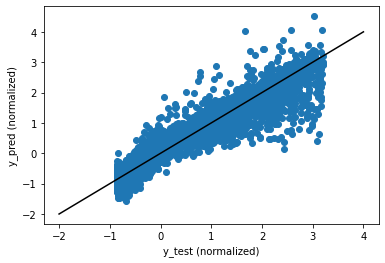

In [38]:
modelAuto(PolyDegree = 2)

Polynomial features up to degree 3

c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.893e+09, tolerance: 1.495e+07
  model = cd_fast.enet_coordinate_descent(


mae: 0.14429930047446848


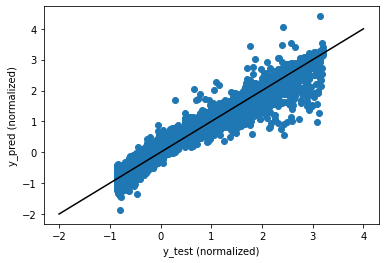

In [39]:
modelAuto(PolyDegree = 3)

Polynomial features up to degree 4

c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e+09, tolerance: 1.495e+07
  model = cd_fast.enet_coordinate_descent(


mae: 0.10216939584812221


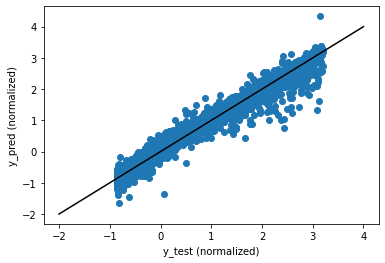

In [40]:
modelAuto(PolyDegree = 4)

Polynomial features up to degree 5

c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e+09, tolerance: 1.495e+07
  model = cd_fast.enet_coordinate_descent(


mae: 0.08667505709431354


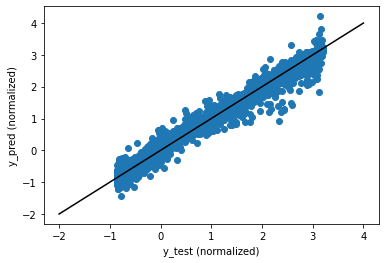

In [41]:
modelAuto(PolyDegree = 5)